In [62]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step, calculate_output

In [165]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        if epoch%100 == 0:
            print('epoch: ', epoch)
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sims(i, trainset, test_sets):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])

    return losses, accs, model

def run_sim(i, trainset, test_sets):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, test_sets, epochs)

    return loss1, acc1, model


def seq_acc(model, testset, hidden_size, rep = 1, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=5)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[j*len(x)+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean()
           
    return df 

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue', 'black']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = 'loss', color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=14)

In [64]:
# params

num_classes = 14
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001


In [117]:
def exp3_pretrain(p, trainseqs1, trainseqs2, testseqs2):
    t1 = time.time()

    for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)            

    # format inputs
    padtrain = pad_seqs_2step(trainseqs1) + p
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtrain = trainseqs2
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    padtest = testseqs2
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    res = Parallel(n_jobs = -1)(delayed(run_sims)(i, [trainset1, trainset2], [trainset1, trainset2, testset]) for i in range(num_sims))

    losses = np.hstack([r[0] for r in res1])
    acc_pretrain = np.array([r[1][:,0] for r in res1]).T
    acc_train = np.array([r[1][:,1] for r in res1]).T
    acc_test = np.array([r[1][:,2] for r in res1]).T
    models = [r[2] for r in res1]

    # calculate test accuracy on each trial type
    dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 1, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

    # plot
    plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')

    t2 = time.time()
    print('time: ', (t2-t1)/60)
    
    return losses, acc_pretrain, acc_train, acc_test, models, dfs

In [121]:
def exp3_train(p, trainseqs1, trainseqs2, testseqs2):
    t1 = time.time()

    for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)            

    # format inputs
    padtest = testseqs2
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    padtrain = pad_seqs_2step(trainseqs1) + p + trainseqs2
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
        
    res = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, [trainset, testset]) for i in range(num_sims))

    losses = np.hstack([r[0] for r in res])
    acc_train = np.array([r[1][:,0] for r in res]).T
    acc_test = np.array([r[1][:,1] for r in res]).T
    models = [r[2] for r in res]

    # calculate test accuracy on each trial type
    dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

    # plot
    plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')

    t2 = time.time()
    print('time: ', (t2-t1)/60)
    
    return losses, acc_train, acc_test, models, dfs

# 2 step

trial
['A', ('+', 'A'), ('+', 'A'), 6]     0.0
['D', ('+', 'A'), ('+', 'E'), 10]    0.0
['D', ('+', 'D'), ('+', 'C'), 19]    0.0
['D', ('+', 'D'), ('+', 'B'), 17]    0.0
['D', ('+', 'D'), ('+', 'A'), 16]    0.0
                                    ... 
['B', ('+', 'C'), ('+', 'C'), 13]    0.0
['B', ('+', 'C'), ('+', 'B'), 11]    0.0
['B', ('+', 'C'), ('+', 'A'), 10]    0.0
['B', ('+', 'B'), ('+', 'E'), 7]     0.0
['E', ('+', 'E'), ('+', 'E'), 3]     0.0
Length: 125, dtype: float64
time:  6.6578941464424135


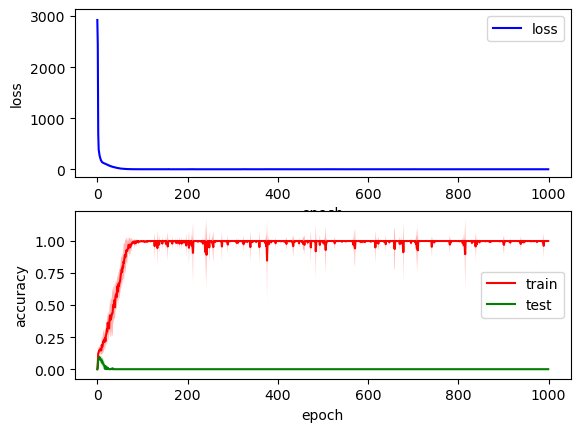

########## rep  4 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  5 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
########## rep  0 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  1 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  7 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
########## rep  6 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.7 
########## rep  3 ##########
epoch:  0
epoch:  100
e

In [126]:
# exp 0 --------- 1 step to 2 step, no primitive

epochs = 1000
num_sims = 8

# trial sequences
p = []

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])

res0 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

trial
['A', ('+', 'A'), ('+', 'A'), 6]     1.000
['C', ('+', 'B'), ('+', 'C'), 13]    1.000
['D', ('+', 'C'), ('+', 'B'), 15]    1.000
['D', ('+', 'C'), ('+', 'A'), 14]    1.000
['D', ('+', 'B'), ('+', 'E'), 11]    1.000
                                     ...  
['D', ('+', 'D'), ('+', 'B'), 17]    0.875
['E', ('+', 'D'), ('+', 'D'), 15]    0.750
['C', ('+', 'D'), ('+', 'D'), 19]    0.625
['B', ('+', 'D'), ('+', 'D'), 17]    0.625
['A', ('+', 'D'), ('+', 'D'), 16]    0.625
Length: 125, dtype: float64
time:  3.635826599597931


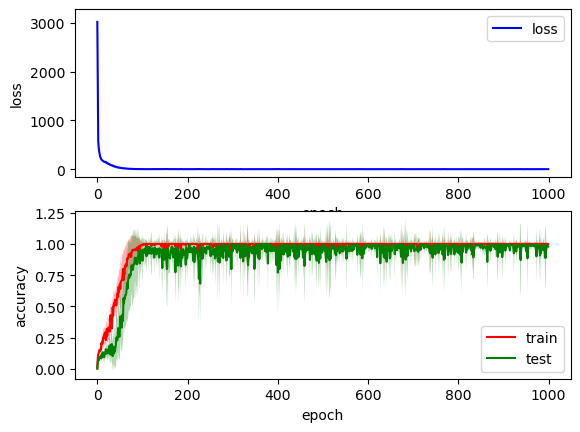

In [123]:
# exp 1 --------- 1 step to 2 step

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])

res1 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

trial
['A', ('+', 'A'), ('+', 'A'), 6]     1.00
['D', ('+', 'C'), ('+', 'E'), 13]    1.00
['D', ('+', 'E'), ('+', 'A'), 10]    1.00
['D', ('+', 'E'), ('+', 'B'), 11]    1.00
['D', ('+', 'E'), ('+', 'C'), 13]    1.00
                                     ... 
['C', ('+', 'F'), ('+', 'F'), 13]    0.50
['B', ('+', 'F'), ('+', 'F'), 11]    0.50
['D', ('+', 'F'), ('+', 'F'), 15]    0.50
['A', ('+', 'F'), ('+', 'F'), 10]    0.50
['F', ('+', 'F'), ('+', 'F'), 12]    0.25
Length: 216, dtype: float64
time:  4.868799273173014


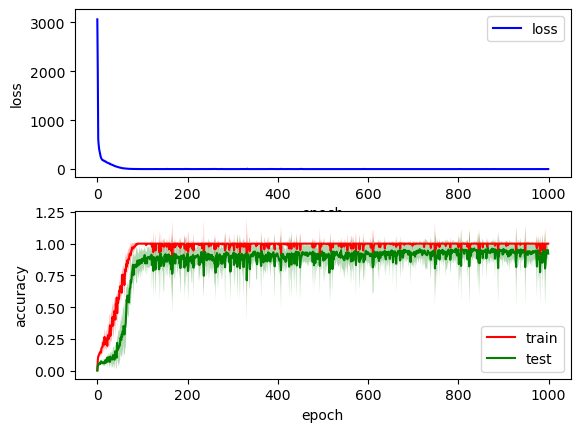

########## rep  4 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.8 
########## rep  7 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.2 
########## rep  2 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  6 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
########## rep  0 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 1.3 
########## rep  3 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.4 
########## rep  5 ##########
epoch:  0
epoch:  100
e

In [125]:
# exp 2 ---------- 

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

res2 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

In [164]:
trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])
trainseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

for val in trainseqs1:
    if val in trainseqs2:
        trainseqs2.remove(val)

In [186]:
fstart = []
fend = []

for t in trainseqs2:
    if ('+', 'F') in t:
        fend.append(t)
        
    else:
        fstart.append(t)

In [193]:
test1 = []
for mod in res2[3]:
    test1.append(seq_acc(mod, trainseqs1, hidden_size))
    
df1 = pd.concat(test1, axis=1)
print(df1.apply(np.mean, axis=1).sort_values(ascending = False))  
df1.apply(np.mean, axis=1).mean()

trial
['A', ('+', 'A'), ('+', 'A'), 6]     1.00
['D', ('+', 'A'), ('+', 'A'), 11]    1.00
['D', ('+', 'D'), ('+', 'E'), 15]    1.00
['D', ('+', 'C'), ('+', 'E'), 13]    1.00
['D', ('+', 'C'), ('+', 'D'), 19]    1.00
                                     ... 
['D', ('+', 'D'), ('+', 'D'), 21]    0.75
['D', ('+', 'D'), ('+', 'C'), 19]    0.75
['D', ('+', 'D'), ('+', 'B'), 17]    0.75
['D', ('+', 'B'), ('+', 'C'), 15]    0.75
['D', ('+', 'B'), ('+', 'B'), 13]    0.75
Length: 125, dtype: float64


0.977

In [192]:
teststart = []
for mod in res2[3]:
    teststart.append(seq_acc(mod, fstart, hidden_size))
    
dftest = pd.concat(teststart, axis=1)
#print(dftest.apply(np.mean, axis=1).sort_values(ascending = False)[:40])  

dftest.apply(np.mean, axis=1).mean()
### first pos v second v third

1.0

In [191]:
testend = []
for mod in res2[3]:
    testend.append(seq_acc(mod, fend, hidden_size))
    
dftest = pd.concat(testend, axis=1)
#print(dftest.apply(np.mean, axis=1).sort_values(ascending = False)[:40])  

dftest.apply(np.mean, axis=1).mean()
### first pos v second v third

0.7878787878787878

In [197]:
testend

[                                   acc
 trial                                 
 ['A', ('+', 'A'), ('+', 'F'), 8]   1.0
 ['A', ('+', 'B'), ('+', 'F'), 9]   1.0
 ['A', ('+', 'C'), ('+', 'F'), 11]  1.0
 ['A', ('+', 'D'), ('+', 'F'), 13]  1.0
 ['A', ('+', 'E'), ('+', 'F'), 7]   1.0
 ...                                ...
 ['F', ('+', 'F'), ('+', 'B'), 11]  1.0
 ['F', ('+', 'F'), ('+', 'C'), 13]  1.0
 ['F', ('+', 'F'), ('+', 'D'), 15]  1.0
 ['F', ('+', 'F'), ('+', 'E'), 9]   0.0
 ['F', ('+', 'F'), ('+', 'F'), 12]  0.0
 
 [66 rows x 1 columns],
                                    acc
 trial                                 
 ['A', ('+', 'A'), ('+', 'F'), 8]   0.0
 ['A', ('+', 'B'), ('+', 'F'), 9]   0.0
 ['A', ('+', 'C'), ('+', 'F'), 11]  0.0
 ['A', ('+', 'D'), ('+', 'F'), 13]  0.0
 ['A', ('+', 'E'), ('+', 'F'), 7]   0.0
 ...                                ...
 ['F', ('+', 'F'), ('+', 'B'), 11]  1.0
 ['F', ('+', 'F'), ('+', 'C'), 13]  1.0
 ['F', ('+', 'F'), ('+', 'D'), 15]  1.0
 ['F', ('+', '

In [162]:
dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  


,acc,acc,acc,acc,acc,acc,acc,acc
trial,,,,,,,,
"['A', ('+', 'A'), ('+', 'A'), 6]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"['A', ('+', 'A'), ('+', 'B'), 7]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"['A', ('+', 'A'), ('+', 'C'), 9]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"['A', ('+', 'A'), ('+', 'D'), 11]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"['A', ('+', 'A'), ('+', 'E'), 5]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
"['F', ('+', 'F'), ('+', 'B'), 11]",1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
"['F', ('+', 'F'), ('+', 'C'), 13]",1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
"['F', ('+', 'F'), ('+', 'D'), 15]",1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


trial
['A', ('+', 'A'), ('+', 'A'), 6]     1.000
['C', ('+', 'E'), ('+', 'E'), 7]     1.000
['D', ('+', 'E'), ('+', 'E'), 9]     1.000
['D', ('+', 'E'), ('+', 'D'), 15]    1.000
['D', ('+', 'E'), ('+', 'C'), 13]    1.000
                                     ...  
['E', ('+', 'F'), ('+', 'D'), 12]    0.750
['C', ('+', 'C'), ('+', 'F'), 14]    0.750
['F', ('+', 'F'), ('+', 'F'), 12]    0.750
['E', ('+', 'F'), ('+', 'F'), 9]     0.625
['A', ('+', 'F'), ('+', 'F'), 10]    0.625
Length: 216, dtype: float64
time:  11.849717315038045


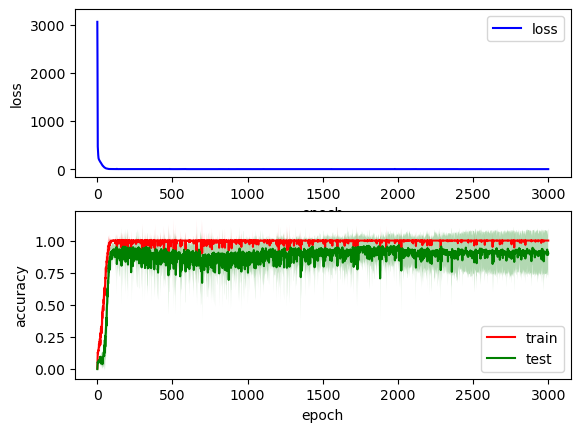

########## rep  5 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
loss: 0.0 
########## rep  3 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
loss: 0.4 
########## rep  1 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoc

In [127]:
# exp 3 ---------- for longer

epochs = 3000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

# format inputs
padtest = testseqs2
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

padtrain = pad_seqs_2step(trainseqs1) + p + trainseqs2
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

res = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, [trainset, testset]) for i in range(num_sims))

losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')

t2 = time.time()
print('time: ', (t2-t1)/60)


"['A', ('+', 'A'), ('+', 'B'), 7]"

In [139]:
testseqs_all = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])
testseqs_f = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])
for val in testseqs_all:
        if val in testseqs_f:
            testseqs_f.remove(val)

trial
['C', ('-', 'A'), ('+', 'A'), 5]     0.875
['D', ('-', 'A'), ('+', 'E'), 6]     0.875
['A', ('-', 'E'), ('-', 'B'), -2]    0.875
['A', ('-', 'E'), ('-', 'C'), -4]    0.875
['A', ('-', 'E'), ('-', 'E'), 0]     0.875
                                     ...  
['E', ('-', 'B'), ('+', 'E'), -1]    0.000
['C', ('-', 'D'), ('+', 'B'), 1]     0.000
['C', ('-', 'D'), ('+', 'A'), 0]     0.000
['B', ('-', 'C'), ('+', 'A'), 0]     0.000
['D', ('-', 'D'), ('+', 'B'), 3]     0.000
Length: 500, dtype: float64
time:  9.981018487612406


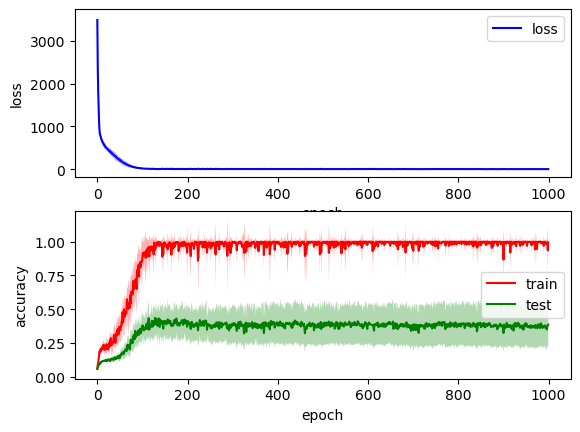

In [199]:
# exp 4 ---------- 

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['-','+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['-','+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])

res4 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

In [201]:
# exp 5 ---------- 

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['-','+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['-','+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

res5 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

KeyboardInterrupt: 

trial
['C', ('-', 'E'), ('-', 'A'), 2]     1.0
['D', ('-', 'E'), ('-', 'E'), 5]     1.0
['C', ('-', 'E'), ('-', 'C'), -1]    1.0
['C', ('-', 'E'), ('-', 'E'), 3]     1.0
['C', ('-', 'E'), ('-', 'B'), 1]     1.0
                                    ... 
['B', ('-', 'C'), ('-', 'C'), -7]    0.0
['B', ('-', 'C'), ('-', 'B'), -5]    0.0
['B', ('-', 'C'), ('-', 'A'), -4]    0.0
['B', ('-', 'B'), ('-', 'E'), -1]    0.0
['C', ('-', 'C'), ('-', 'C'), -5]    0.0
Length: 125, dtype: float64
time:  3.4582997520764667


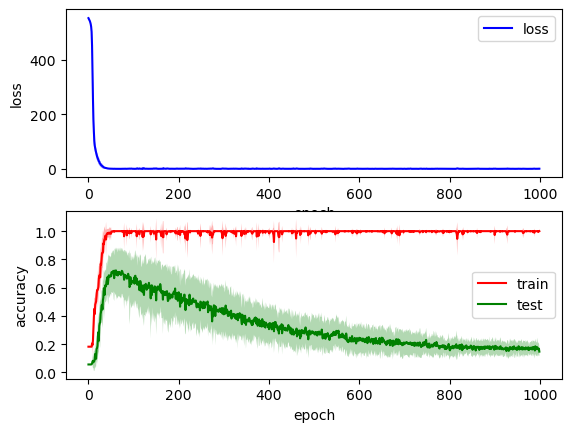

########## rep  1 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.7 
########## rep  5 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.3 
########## rep  0 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.2 
########## rep  7 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 3.0 
########## rep  6 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.5 
########## rep  4 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.2 
########## rep  2 ##########
epoch:  0
epoch:  100
e

In [204]:
# exp 6 ---------- '-' only 

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]
    ]

trainseqs1 = generate_sequences(['-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = []
testseqs2 = generate_sequences(['-'], ['A','B','C', 'D', 'E' ], len_seq = 2, init_values = ['A','B','C', 'D', 'E'])

res6 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

trial
['D', ('-', 'E'), ('-', 'B'), 3]     1.0
['B', ('-', 'E'), ('-', 'A'), 0]     1.0
['B', ('-', 'E'), ('-', 'E'), 1]     1.0
['D', ('-', 'E'), ('-', 'A'), 4]     1.0
['C', ('-', 'E'), ('-', 'A'), 2]     1.0
                                    ... 
['B', ('-', 'F'), ('-', 'F'), -5]    0.0
['C', ('-', 'B'), ('-', 'C'), -3]    0.0
['C', ('-', 'B'), ('-', 'D'), -5]    0.0
['C', ('-', 'C'), ('-', 'A'), -2]    0.0
['F', ('-', 'F'), ('-', 'F'), -4]    0.0
Length: 216, dtype: float64
time:  5.492801241079966


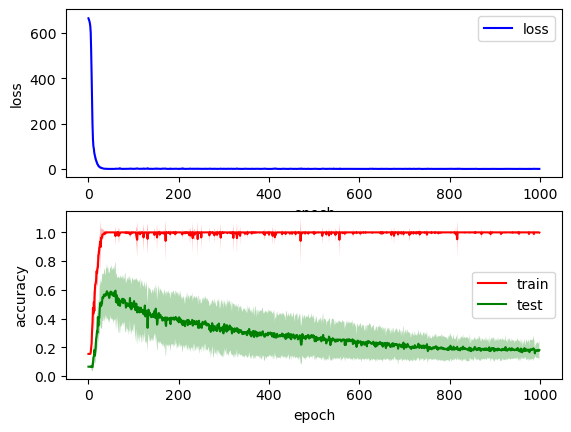

In [205]:
# exp 7 ---------- '-' only 

epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E', 'F'])
trainseqs2 = []
testseqs2 = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F' ], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

res7 = exp3_train(p, trainseqs1, trainseqs2, testseqs2)

In [ ]:
# Exp 1 : 2 step trials in training

trial
['A', ('+', 'A'), ('+', 'F'), 8]     1.000
['E', ('+', 'A'), ('+', 'F'), 7]     1.000
['F', ('+', 'B'), ('+', 'E'), 8]     1.000
['F', ('+', 'B'), ('+', 'D'), 14]    1.000
['F', ('+', 'B'), ('+', 'C'), 12]    1.000
                                     ...  
['F', ('+', 'D'), ('+', 'F'), 15]    0.875
['F', ('+', 'C'), ('+', 'F'), 13]    0.875
['C', ('+', 'F'), ('+', 'F'), 13]    0.875
['E', ('+', 'F'), ('+', 'F'), 9]     0.875
['D', ('+', 'F'), ('+', 'F'), 15]    0.750
Length: 91, dtype: float64
time:  6.938390485445658


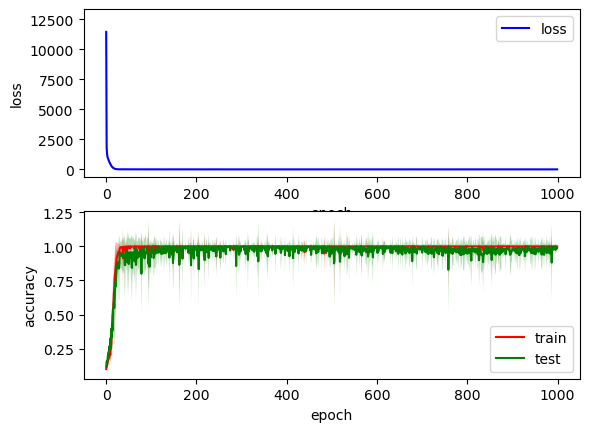

In [105]:
# hidden = 20
epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B', 'C',  'D', 'E'])
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])
for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)            

# format inputs
padtrain = pad_seqs_2step(trainseqs1) + p + trainseqs2
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = testseqs2
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
t1 = time.time()
# run
res1 = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, [trainset, testset]) for i in range(num_sims))

losses = np.hstack([r[0] for r in res1])
acc_train = np.array([r[1][:,0] for r in res1]).T
acc_test = np.array([r[1][:,1] for r in res1]).T
models = [r[2] for r in res1]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')

t2 = time.time()
print('time: ', (t2-t1)/60)

In [ ]:
# Exp 2: pretraining then train on 2 step

trial
['E', ('+', 'F'), ('+', 'B'), 8]     0.875
['A', ('+', 'F'), ('+', 'E'), 7]     0.875
['E', ('+', 'F'), ('+', 'A'), 7]     0.875
['B', ('+', 'F'), ('+', 'E'), 8]     0.875
['B', ('+', 'F'), ('+', 'D'), 14]    0.875
                                     ...  
['F', ('+', 'B'), ('+', 'F'), 11]    0.250
['B', ('+', 'F'), ('+', 'F'), 11]    0.250
['F', ('+', 'A'), ('+', 'F'), 10]    0.250
['D', ('+', 'F'), ('+', 'F'), 15]    0.125
['F', ('+', 'F'), ('+', 'F'), 12]    0.125
Length: 91, dtype: float64
time:  16.34422008196513


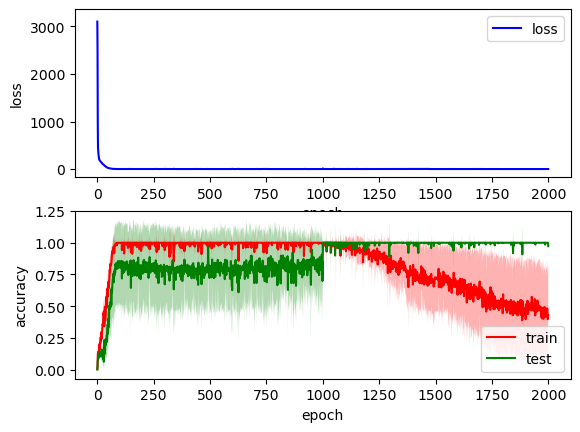

########## rep  2 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.3 
########## rep  0 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.6 
########## rep  0 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  4 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.3 
########## rep  2 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep  1 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:

In [106]:
# hidden = 20
epochs = 1000
num_sims = 8

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
trainseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 2, init_values = ['A','B', 'C',  'D', 'E'])
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])

for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)            

# format inputs
padtrain = pad_seqs_2step(trainseqs1) + p
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtrain = trainseqs2
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtest = testseqs2
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
res2 = Parallel(n_jobs = -1)(delayed(run_sims)(i, [trainset1, trainset2], [trainset1, trainset2, testset]) for i in range(num_sims))

losses = np.hstack([r[0] for r in res2])
acc_pretrain = np.array([r[1][:,0] for r in res2]).T
acc_train = np.array([r[1][:,1] for r in res2]).T
accs_test = np.array([r[1][:,2] for r in res2]).T
models = [r[2] for r in res2]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')

t2 = time.time()
print('time: ', (t2-t1)/60)

In [113]:
accs_trans = np.array([r[1][:,2] for r in res2]).T

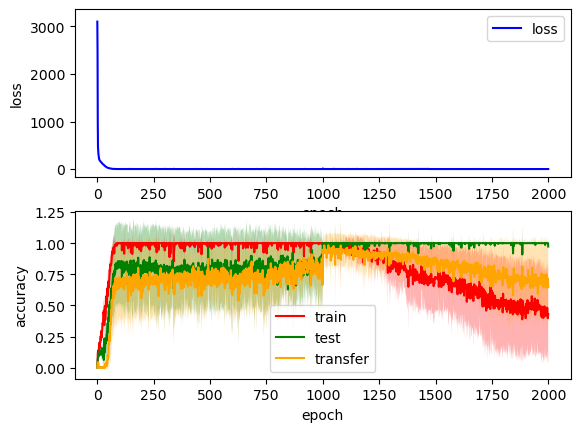

In [114]:
plotNNs([losses], [acc_train, acc_test, accs_trans], ['train', 'test', 'transfer'], ['red', 'green', 'orange'], '')


In [110]:
accs[0].shape

(2000, 3)

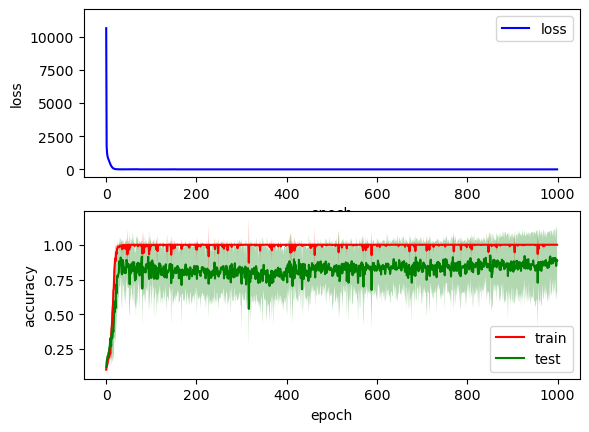

In [104]:
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')


In [93]:
# hidden = 20
epochs = 600

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','F', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'F',  'D', 'E'])
trainseqs2 = generate_sequences(['+'], ['A','B','F', 'D', 'E'], len_seq = 2, init_values = ['A','B', 'F',  'D', 'E'])
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])
for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)            

# format inputs
padtrain = pad_seqs_2step(trainseqs1) + p + testseqs2[0:3]
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = testseqs2[3:]
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run 
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss2, acc2 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)


epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
loss: 0.1 


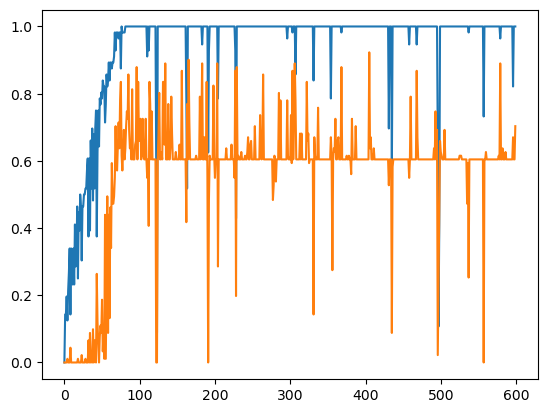

In [88]:
plt.plot(acc2)

In [90]:
seq_acc(model, testseqs2, hidden_size).sort_values(by='acc', ascending= False)

,acc
trial,
"['C', ('+', 'D'), ('+', 'F'), 16]",1.0
"['C', ('+', 'D'), ('+', 'E'), 13]",1.0
"['C', ('+', 'E'), ('+', 'F'), 10]",1.0
"['C', ('+', 'E'), ('+', 'E'), 7]",1.0
"['C', ('+', 'E'), ('+', 'D'), 13]",1.0
...,...
"['C', ('+', 'C'), ('+', 'C'), 15]",0.0
"['A', ('+', 'B'), ('+', 'C'), 10]",0.0
"['C', ('+', 'E'), ('+', 'C'), 11]",0.0


In [67]:
# hidden = 20
epochs = 1200

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs1 = generate_sequences(['+'], ['A','B','F', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'F',  'D', 'E'])
trainseqs2 = generate_sequences(['+'], ['A','B','F', 'D', 'E'], len_seq = 2, init_values = ['A','B', 'F',  'D', 'E'])
testseqs2 = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 2, init_values = ['A','B','C', 'D', 'E', 'F'])
for val in trainseqs2:
        if val in testseqs2:
            testseqs2.remove(val)
            
train_trials = trainseqs1 + p


# format inputs
padtrain = pad_seqs_2step(trainseqs1) + p
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = test_trials
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run 
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)




[['A', ('+', 'A'), 4],
 ['A', ('+', 'B'), 5],
 ['A', ('+', 'F'), 6],
 ['A', ('+', 'D'), 9],
 ['A', ('+', 'E'), 3],
 ['B', ('+', 'A'), 5],
 ['B', ('+', 'B'), 6],
 ['B', ('+', 'F'), 7],
 ['B', ('+', 'D'), 10],
 ['B', ('+', 'E'), 4],
 ['F', ('+', 'A'), 6],
 ['F', ('+', 'B'), 7],
 ['F', ('+', 'F'), 8],
 ['F', ('+', 'D'), 11],
 ['F', ('+', 'E'), 5],
 ['D', ('+', 'A'), 9],
 ['D', ('+', 'B'), 10],
 ['D', ('+', 'F'), 11],
 ['D', ('+', 'D'), 14],
 ['D', ('+', 'E'), 8],
 ['E', ('+', 'A'), 3],
 ['E', ('+', 'B'), 4],
 ['E', ('+', 'F'), 5],
 ['E', ('+', 'D'), 8],
 ['E', ('+', 'E'), 2]]

In [55]:
padtrain = pad_seqs_2step(train_trials)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(test_trials)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)


In [56]:
loss, acc, mod = run_sim(1, trainset, [trainset, testset])

########## rep  1 ##########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 0.0 


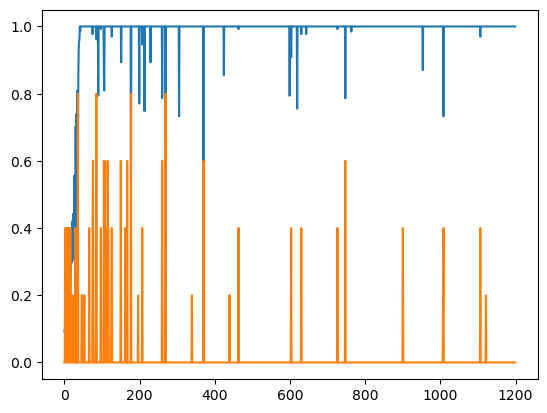

In [57]:
plt.plot(acc)

In [40]:
res = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, testset) for i in range(num_sims))


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
    padtrain = pad_seqs_2step(train_trials)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(test_trials)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    # run
    t1 = time.time()
    res = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, testset) for i in range(num_sims))

    # format results
    losses = np.hstack([r[0] for r in res])
    acc_train = np.array([r[1][:,0] for r in res]).T
    acc_test = np.array([r[1][:,1] for r in res]).T
    models = [r[2] for r in res]

    # calculate test accuracy on each trial type
    dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  
    
    # plot
    plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')
    
    t2 = time.time()
    print('time: ', (t2-t1)/60)
    return losses, acc_train, acc_test, dfs, models

In [96]:
# hidden = 20
epochs = 1000

# trial sequences
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+'], ['A','C'], len_seq = 1, init_values = ['A','C'])
testseqs = generate_sequences(['+'], ['A','B','C'], len_seq = 1, init_values = ['A','B','C'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)

# format inputs
padtrain1 = p
train_inputs = convert_seq2inputs(padtrain1, num_classes=num_classes, seq_len=5)
trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtrain2 = pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain2, num_classes=num_classes, seq_len=5)
trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtest =  testseqs
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run 
model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
loss1, acc1 = run_acc(model,optimizer,criterion, trainset1, [trainset2, testset], epochs)
loss2, acc2 = run_acc(model,optimizer,criterion, trainset2, [trainset2, testset], epochs)

losses = loss1 + loss2
accs = np.vstack([acc1,acc2])


epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 


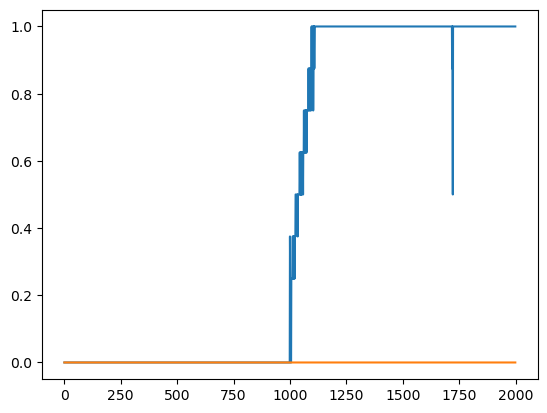

In [97]:
plt.plot(accs)